In [1]:
import os
import re
import sys
from pathlib import Path

import h5py
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import skimage
from joblib import Parallel, delayed
from skimage import exposure, io
from tqdm.notebook import tqdm, trange

sc.settings.verbosity = 3

from functools import reduce

import anndata as ad
import scanorama
import seaborn as sns
from matplotlib import cm, colors
from matplotlib.pyplot import rc_context
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
import multiprocessing

n_cpu = multiprocessing.cpu_count()

In [3]:
p_dir = (Path().cwd().parents[0]).absolute()
data_dir = p_dir / "data"

In [4]:
%load_ext autoreload
%autoreload 2

module_path = str(p_dir / "src")

if module_path not in sys.path:
    sys.path.append(module_path)


In [5]:
donors = [
    "LN Donor A",
    "LN Donor E",
    "INT Donor B",
    "INT Donor E",
    "TS Donor A",
    "TS Donor E",
    "SP Donor A"
]


In [6]:
adata_path = data_dir / "metadata" / f"combined_10_07.h5ad"
adata = sc.read_h5ad(adata_path)

# Plot small window to show radius 

In [7]:
# Import spatial omics library
import athena as ath
from spatialOmics import SpatialOmics

# import default graph builder parameters
from athena.graph_builder.constants import GRAPH_BUILDER_DEFAULT_PARAMS
from matplotlib.colors import ListedColormap

# Read mask image
def get_masks(mask_folder):
    """
    Function to get all mask from mask forlder
    """
    # Read masks
    masks = {}

    for (dirpath, dirnames, filenames) in os.walk(mask_folder):
        for name in sorted(filenames):
            if "tif" in name:
                filename = os.path.join(dirpath, name)
                img = skimage.io.imread(filename)
                condition =  name.split(".")[0]
                masks[condition] = img
            else:
                continue
    return masks

In [8]:
# # Create spatial omics data objects
# spadata = SpatialOmics()
# spl = pd.DataFrame({'Dataset': adata.obs.Dataset.unique()})
# spadata.spl = spl
# n_ROI = 7

# for d in adata.obs.Dataset.unique():
#     # Get 1 ROI per dataset
#     adata_subset = adata[adata.obs.Dataset == d, :]
#     adata_subset = adata_subset[adata_subset.obs.ROI == n_ROI]
    
#     # Get masks 
#     masks = get_masks(data_dir / "masks" / d)
    
#     obs = adata_subset.obs.copy()
#     obs['x'] = adata_subset.obsm['spatial'][:,1].tolist()
#     obs['y'] = adata_subset.obsm['spatial'][:,0].tolist()
#     obs['cell_id'] = obs['Cell']
#     obs = obs.set_index('cell_id')
#     spadata.obs[d] = obs
#     spadata.X[d] = pd.DataFrame(adata_subset.X, columns=adata_subset.var_names, index=adata_subset.obs.Cell.tolist())
#     spadata.var[d] = adata_subset.var
#     spadata.masks[d] = {'cellmasks': masks[str(n_ROI)]}

In [9]:
# # Loop through all region and create different cell neighborhood graph
# datasets = spadata.spl.Dataset

# for spl in datasets:
#     # kNN graph
#     config = GRAPH_BUILDER_DEFAULT_PARAMS['knn']
#     config['builder_params']['n_neighbors'] = 6 # set parameter k
#     ath.graph.build_graph(spadata, spl, builder_type='knn', mask_key='cellmasks', config=config)

#     # Contact graph
#     config = GRAPH_BUILDER_DEFAULT_PARAMS['contact']
#     config['builder_params']['radius'] = 1 # set parameter k
#     ath.graph.build_graph(spadata, spl, builder_type='contact', mask_key='cellmasks',  config=config)
    
#     # Radius graph
#     config = GRAPH_BUILDER_DEFAULT_PARAMS['radius']
#     config['builder_params']['radius'] = 15 # set radius
#     ath.graph.build_graph(spadata, spl, builder_type='radius', mask_key='cellmasks', config=config)


In [10]:
# spadata.to_h5py()

In [11]:
spadata = SpatialOmics().from_h5py(file='spatialOmics.h5py')
spadata


SpatialOmics object with 110481 observations across 7 samples.
    X: 7 samples,
    spl: 7 samples,
        columns: ['Dataset']
    obs: 7 samples,
        columns: ['merged', 'leiden', 'ROI', 'Cell', 'y', 'x', 'Dataset']
    var: 0 samples,
        columns: []
    G: 7 samples,
        keys: ['knn', 'contact', 'radius']
    masks: 7 samples
        keys: [{'cellmasks'}]
    images: 0 samples

In [12]:
# for spl in adata.obs.Dataset.unique():
#     fig, axs = plt.subplots(1, 3, figsize=(15, 6), dpi=100)
#     ath.pl.spatial(spadata, spl, 'merged', edges=True, graph_key='knn', node_size=1, ax=axs.flat[0], cbar=False)
#     ath.pl.spatial(spadata, spl, 'merged', edges=True, graph_key='radius', node_size=1, ax=axs.flat[1], cbar=False)
#     ath.pl.spatial(spadata, spl, 'merged', edges=True, graph_key='contact', node_size=1, ax=axs.flat[2], cbar=False)
#     plt.show()
#     break

# LDA

## Run Spatial LDA pipeline

In [13]:
import spatial as sm
from sklearn.cluster import MiniBatchKMeans
from kneed import KneeLocator
from matplotlib.ticker import MaxNLocator

In [14]:
# Spatial LDA need centroid info as indivisual obs
adata.obs['X_centroid'] = adata.obsm['spatial'][:,0]
adata.obs['Y_centroid'] = adata.obsm['spatial'][:,1]


In [15]:
adata = sm.tl.spatial_lda(adata, num_motifs=10, radius=30, knn=20, method='radius', imageid='Dataset', phenotype='merged')

Processing: ['LN Donor A']
Identifying neighbours within 30 pixels of every cell
Processing: ['LN Donor E']
Identifying neighbours within 30 pixels of every cell
Processing: ['INT Donor B']
Identifying neighbours within 30 pixels of every cell
Processing: ['INT Donor E']
Identifying neighbours within 30 pixels of every cell
Processing: ['TS Donor A']
Identifying neighbours within 30 pixels of every cell
Processing: ['TS Donor E']
Identifying neighbours within 30 pixels of every cell
Processing: ['SP Donor A']
Identifying neighbours within 30 pixels of every cell


INFO:gensim.corpora.dictionary:adding document #0 to Dictionary<0 unique tokens: []>
INFO:gensim.corpora.dictionary:adding document #10000 to Dictionary<13 unique tokens: ['4', '5', '1', '3', '6']...>


Pre-Processing Spatial LDA


INFO:gensim.corpora.dictionary:adding document #20000 to Dictionary<13 unique tokens: ['4', '5', '1', '3', '6']...>
INFO:gensim.corpora.dictionary:adding document #30000 to Dictionary<14 unique tokens: ['4', '5', '1', '3', '6']...>
INFO:gensim.corpora.dictionary:adding document #40000 to Dictionary<15 unique tokens: ['4', '5', '1', '3', '6']...>
INFO:gensim.corpora.dictionary:adding document #50000 to Dictionary<15 unique tokens: ['4', '5', '1', '3', '6']...>
INFO:gensim.corpora.dictionary:adding document #60000 to Dictionary<15 unique tokens: ['4', '5', '1', '3', '6']...>
INFO:gensim.corpora.dictionary:adding document #70000 to Dictionary<15 unique tokens: ['4', '5', '1', '3', '6']...>
INFO:gensim.corpora.dictionary:adding document #80000 to Dictionary<15 unique tokens: ['4', '5', '1', '3', '6']...>
INFO:gensim.corpora.dictionary:adding document #90000 to Dictionary<15 unique tokens: ['4', '5', '1', '3', '6']...>
INFO:gensim.corpora.dictionary:adding document #100000 to Dictionary<15 

Training Spatial LDA


INFO:gensim.models.ldamulticore:PROGRESS: pass 0, dispatched chunk #0 = documents up to #2000/1955450, outstanding queue size 1
INFO:gensim.models.ldamulticore:PROGRESS: pass 0, dispatched chunk #1 = documents up to #4000/1955450, outstanding queue size 2
INFO:gensim.models.ldamulticore:PROGRESS: pass 0, dispatched chunk #2 = documents up to #6000/1955450, outstanding queue size 3
INFO:gensim.models.ldamulticore:PROGRESS: pass 0, dispatched chunk #3 = documents up to #8000/1955450, outstanding queue size 4
INFO:gensim.models.ldamulticore:PROGRESS: pass 0, dispatched chunk #4 = documents up to #10000/1955450, outstanding queue size 5
INFO:gensim.models.ldamulticore:PROGRESS: pass 0, dispatched chunk #5 = documents up to #12000/1955450, outstanding queue size 6
INFO:gensim.models.ldamulticore:PROGRESS: pass 0, dispatched chunk #6 = documents up to #14000/1955450, outstanding queue size 7
INFO:gensim.models.ldamulticore:PROGRESS: pass 0, dispatched chunk #7 = documents up to #16000/195545

Calculating the Coherence Score


INFO:gensim.topic_coherence.text_analysis:47 accumulators retrieved from output queue
INFO:gensim.topic_coherence.text_analysis:accumulated word occurrence stats for 1961896 virtual documents



Coherence Score:  0.35706769139861716
Gathering the latent weights


INFO:gensim.models.ldamodel:topic #0 (0.100): 0.373*"2" + 0.321*"1" + 0.058*"4" + 0.055*"0" + 0.053*"6" + 0.046*"7" + 0.025*"9" + 0.025*"3" + 0.023*"5" + 0.016*"8"
INFO:gensim.models.ldamodel:topic #1 (0.100): 0.543*"1" + 0.229*"9" + 0.070*"8" + 0.047*"2" + 0.032*"6" + 0.023*"7" + 0.017*"5" + 0.016*"3" + 0.007*"0" + 0.006*"4"
INFO:gensim.models.ldamodel:topic #2 (0.100): 0.375*"0" + 0.265*"2" + 0.201*"5" + 0.100*"4" + 0.017*"3" + 0.010*"6" + 0.009*"1" + 0.008*"7" + 0.007*"10" + 0.004*"9"
INFO:gensim.models.ldamodel:topic #3 (0.100): 0.480*"3" + 0.102*"5" + 0.098*"4" + 0.076*"10" + 0.064*"11" + 0.050*"0" + 0.028*"6" + 0.026*"8" + 0.023*"7" + 0.017*"2"
INFO:gensim.models.ldamodel:topic #4 (0.100): 0.381*"4" + 0.156*"5" + 0.137*"3" + 0.087*"12" + 0.044*"6" + 0.031*"8" + 0.031*"9" + 0.030*"1" + 0.028*"7" + 0.028*"10"
INFO:gensim.models.ldamodel:topic #5 (0.100): 0.352*"8" + 0.310*"5" + 0.155*"11" + 0.055*"3" + 0.045*"6" + 0.042*"4" + 0.016*"9" + 0.007*"0" + 0.005*"10" + 0.005*"1"
INFO:gens

In [16]:
adata_CN = ad.AnnData(adata.uns['spatial_lda'].values)
adata_CN.raw = adata.copy()
adata_CN.obs = adata.obs.copy()
adata_CN.uns = adata.uns.copy()
adata_CN.obsm = adata.obsm.copy()
adata_CN.obsp = adata.obsp.copy() 
adata_CN.var_names = adata.uns['spatial_lda'].columns.tolist()

## LDA motifs K-means clustering

C:\Users\thu71\.conda\envs\scanpy\lib\site-packages\sklearn\cluster\_kmeans.py:1836: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 12288 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Users\thu71\.conda\envs\scanpy\lib\site-packages\sklearn\cluster\_kmeans.py:1836: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 12288 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Users\thu71\.conda\envs\scanpy\lib\site-packages\sklearn\cluster\_kmeans.py:1836: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 12288 or by setting the environment variable OMP_NUM_THRE

The suggested number of clusters =  18


C:\Users\thu71\AppData\Local\Temp\ipykernel_100096\348357271.py:30: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  plt.title("The suggested number of clusters = " + np.str(kneedle_point.knee))


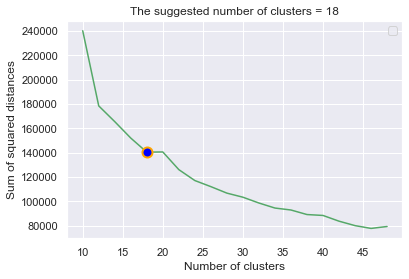

In [17]:
proj_3d = adata_CN.X

n_components = np.arange(10, 50, step=2)
models = [
    MiniBatchKMeans(random_state=5, n_clusters=n).fit(proj_3d) for n in n_components
]

BIC_Scores = [m.inertia_ for m in models]
kneedle_point = KneeLocator(
    n_components, BIC_Scores, curve="convex", direction="decreasing"
)
print("The suggested number of clusters = ", kneedle_point.knee)
Elbow_idx = np.where(BIC_Scores == kneedle_point.knee_y)[0]

plt.plot(
    n_components,
    BIC_Scores,
    "-g",
    marker="o",
    markerfacecolor="blue",
    markeredgecolor="orange",
    markeredgewidth="2",
    markersize=10,
    markevery=Elbow_idx,
)
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.legend(loc="best")
plt.xlabel("Number of clusters")
plt.ylabel("Sum of squared distances")
plt.title("The suggested number of clusters = " + np.str(kneedle_point.knee))
plt.show()

In [19]:
n_neighborhoods = 18

km = MiniBatchKMeans(n_clusters=n_neighborhoods, random_state=0)

labels = km.fit_predict(adata.X)
k_centroids = km.cluster_centers_

C:\Users\thu71\.conda\envs\scanpy\lib\site-packages\sklearn\cluster\_kmeans.py:1836: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 12288 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(


## Merge clusters based on dendrogram

In [20]:
import matplotlib

In [ ]:
labels = km.fit_predict(adata_CN.X)


C:\Users\thu71\.conda\envs\scanpy\lib\site-packages\sklearn\cluster\_kmeans.py:1836: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 12288 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(


In [ ]:
df_cluster = pd.DataFrame()
df_cluster["Clusters"] = labels
df_cluster["Clusters"] = df_cluster["Clusters"].astype(str).astype('category')
df_cluster["Leiden"] = adata.obs['merged'].tolist()
df_cluster_count = df_cluster.value_counts().to_frame('counts').reset_index()

df_cluster_count['Density'] = df_cluster_count.groupby('Clusters')["counts"].apply(lambda x: x / x.sum())

clusters = df_cluster["Clusters"].unique().tolist()
clusters.sort(key=int)

In [ ]:
var = 'merged'

cluster_label_order = adata.uns[f'dendrogram_{var}']['categories_ordered']

colors = adata.uns[f"{var}_colors"]
labels = adata.obs[var].cat.categories.tolist()
colors_rgb = []
for color in colors:
    colors_rgb.append(matplotlib.colors.hex2color(color))
colors_rgb = np.array(colors_rgb) * 255
colors_rgb = colors_rgb.astype(np.uint8)

colors_rgb_dict = {k:v/255 for k,v in zip(labels, colors_rgb)}

In [ ]:
with sns.plotting_context('talk', font_scale=2):
    fig, ax = plt.subplots(figsize=(20, 9))
    ax = sns.histplot(data=df_cluster_count, x='Clusters' , hue='Leiden', weights='Density', discrete=True, multiple='stack', shrink=0.5, palette=colors_rgb_dict, edgecolor='k',)
    ax.set_ylabel('Density')

    # Fix the legend so it's not on top of the bars.
    legend = ax.get_legend()
    legend.set_bbox_to_anchor((1, 1))


In [ ]:
# Plot count
df_count = (
 df_cluster_count.loc[:,['Clusters', 'Leiden', 'Density']]
 .pivot(index='Clusters', columns='Leiden')
 .fillna(0)
 .droplevel(0, axis=1)
)

adata_count = sc.AnnData(df_count.values)
adata_count.var_names = df_count.columns.tolist()
adata_count.obs['Clusters'] = df_count.index.tolist()
adata_count.obs['Clusters'] = adata_count.obs['Clusters'].astype('category')

In [ ]:
sc.pl.matrixplot(
    adata_count,
    adata_count.var_names.tolist(),
    "Clusters",
    dendrogram=True,
    colorbar_title="Cluster Distribution",
    cmap="jet",
    use_raw=False,
    standard_scale='obs'
)

In [ ]:
# Plot stand alone dendrogram
from scanpy.plotting._anndata import _plot_dendrogram

fig, dendro_ax = plt.subplots(1, 1, figsize=(10,5))
_plot_dendrogram(dendro_ax, adata_count, groupby="Clusters", orientation='top', remove_labels=False)

In [176]:
type_dict = {'10': '1',
             '18': '1',
             '6': '4',
            '16':'2', 
            '7': '0',
             '12':'17',
             '13':'11',
             '9':'11',
             '3':'8'
            }

In [177]:
adata_count.obs['CN'] = (
    adata_count.obs['Clusters']
    .map(lambda x: type_dict.get(x, x))
    .astype("category")
)


    using data matrix X directly
Storing dendrogram info using `.uns['dendrogram_CN']`


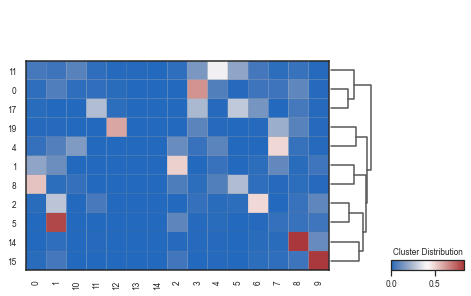

In [180]:
sc.tl.dendrogram(adata_count, 'CN')
sc.pl.matrixplot(
    adata_count,
    adata_count.var_names.tolist(),
    "CN",
    dendrogram=True,
    colorbar_title="Cluster Distribution",
    cmap="vlag",
    use_raw=False,
    standard_scale='obs'
)

# Add clustering labels to adata

In [181]:
labels = np.array(km.fit_predict(adata_CN.X)).astype(str)

C:\Users\thu71\.conda\envs\scanpy\lib\site-packages\sklearn\cluster\_kmeans.py:1836: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 12288 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(


In [182]:
adata_CN.obs["LDA_Kmeans"] = labels
adata_CN.obs['CN'] = (
    adata_CN.obs["LDA_Kmeans"]
    .map(lambda x: type_dict.get(x, x))
    .astype("category")
)

adata_CN.obs["CN"] = adata_CN.obs["CN"].astype("category")
adata_CN.uns["CN_colors"] = sc.pl.palettes.vega_20[:len(np.unique(adata_CN.obs['CN']))]

# Reorder cat
clusters = np.unique(adata_CN.obs["CN"]).tolist()
clusters.sort(key=int)
adata_CN.obs["CN"] = adata_CN.obs["CN"].cat.reorder_categories(clusters)

In [183]:
donors = adata_CN.obs.Dataset.unique()
dfs = []

for donor in donors:
    adata_subset = adata_CN[adata_CN.obs.Dataset == donor,:]
    
    # Summary of the phenotyping
    
    df = pd.DataFrame(adata_subset.obs['CN'].value_counts())
    df.columns=[donor]
    dfs.append(df)
    
df = pd.concat(dfs, axis=1)

In [184]:
df.to_clipboard()

In [185]:
df

,LN Donor A,LN Donor E,INT Donor B,INT Donor E,TS Donor A,TS Donor E,SP Donor A
8,38370,72577,17250,8209,45498,52795,25843
11,35685,35955,25502,32130,31722,66944,113302
1,32749,36806,56723,75162,52180,57636,24644
5,18562,38941,8973,6691,9269,9898,1541
17,17275,38034,21015,57645,39966,22343,7698
2,17181,20557,3294,1819,38183,78002,52977
4,15405,17056,14608,40316,34040,17469,60486
0,12294,11332,9393,46069,25855,34245,5355
19,3447,1014,32677,1491,559,895,13129
14,1592,8758,807,246,32237,13279,720


# Plot cell mask

In [186]:
import matplotlib 
from PIL import Image

def create_clustered_cell(mask, label2cell, my_cmap, **kwargs):
    img = np.zeros((mask.shape[0], mask.shape[1],3), dtype=np.uint8)

    # for i, cells in tqdm(label2cell.items(), total=len(label2cell), leave=False):
    for i, cells in label2cell.items():
        rows, cols = np.where(np.isin(mask, cells))
        img[rows, cols, :] = my_cmap[int(i)]
    return img


def get_img_size(roi_dict, size=1000):
    row_max = 0
    col_max = 0
    for k, v in roi_dict.items():
        row_max = max(row_max, v[0])
        col_max = max(col_max, v[1])
    return row_max + size, col_max + size

# Read mask image
def get_masks(mask_folder):
    """
    Function to get all mask from mask forlder
    """
    # Read masks
    masks = {}

    for (dirpath, dirnames, filenames) in os.walk(mask_folder):
        for name in sorted(filenames):
            if "tif" in name:
                filename = os.path.join(dirpath, name)
                img = skimage.io.imread(filename)
                condition =  name.split(".")[0]
                masks[condition] = img
            else:
                continue
    return masks


In [187]:
# Format row, col
arrangement = {
    "LN Donor A": {
        1: [0, 1000],
        2: [0, 2000],
        3: [1000, 0],
        4: [1000, 1000],
        5: [1000, 2000],
        6: [1000, 3000],
        7: [2000, 0],
        8: [2000, 1000],
        9: [2000, 2000],
        10: [2000, 3000],
        11: [3000, 0],
        12: [3000, 1000],
        13: [3000, 2000],
        14: [3000, 3000],
        15: [4000, 1000],
        16: [4000, 2000],
    },
    "LN Donor E": {
        1: [1000, 0],
        2: [1000, 1000],
        3: [1000, 2000],
        4: [1000, 3000],
        5: [1000, 4000],
        6: [1000, 5000],
        7: [1000, 6000],
        8: [1000, 7000],
        9: [1000, 8000],
        10: [0, 0],
        11: [0, 1000],
        12: [0, 2000],
        13: [0, 3000],
        14: [0, 4000],
    },
    "INT Donor B": {
        1: [0, 0],
        2: [0, 1000],
        3: [1000, 0],
        4: [1000, 1000],
        5: [2000, 0],
        6: [2000, 1000],
        7: [2000, 2000],
        8: [2000, 3000],
        9: [3000, 0],
        10: [3000, 1000],
        11: [3000, 2000],
        12: [3000, 3000],
        13: [4000, 0],
        14: [4000, 1000],
        15: [4000, 2000],
        16: [4000, 3000],
        # 17: [5000, 0],
        # 18: [5000, 1000],
        # 19: [5000, 2000],
        # 20: [5000, 3000],
    },
    "INT Donor E": {
        1: [0, 0],
        2: [0, 1000],
        3: [0, 2000],
        4: [0, 3000],
        # 5: [0, 4000],
        6: [1000, 0],
        7: [1000, 1000],
        8: [1000, 2000],
        9: [1000, 3000],
        10: [1000, 4000],
        11: [2000, 3000],
        12: [2000, 4000],
        13: [3000, 3000],
        14: [3000, 4000],
        15: [4000, 3000],
        16: [4000, 4000],
    },
    "TS Donor A": {
        1: [0, 0],
        2: [0, 1000],
        3: [0, 2000],
        4: [0, 3000],
        5: [0, 4000],
        6: [0, 5000],
        7: [0, 6000],
        8: [1000, 0],
        9: [1000, 1000],
        10: [1000, 2000],
        11: [1000, 3000],
        12: [1000, 4000],
        13: [1000, 5000],
        14: [1000, 6000],
    },
    "TS Donor E": {
        1: [0, 0],
        2: [0, 1000],
        3: [0, 2000],
        4: [1000, 0],
        5: [1000, 1000],
        6: [1000, 2000],
        7: [2000, 0],
        8: [2000, 1000],
        9: [2000, 2000],
        10: [3000, 0],
        11: [3000, 1000],
        12: [3000, 2000],
        13: [4000, 0],
        14: [4000, 1000],
        15: [4000, 2000],
        16: [5000, 0],
        17: [5000, 1000],
        18: [5000, 2000],
    },
    "SP Donor A": {
        1: [0, 0],
        2: [0, 1000],
        3: [0, 2000],
        4: [0, 3000],
        5: [0, 4000],
        6: [1000, 0],
        7: [1000, 1000],
        8: [1000, 2000],
        9: [1000, 3000],
        10: [1000, 4000],
        11: [2000, 0],
        12: [2000, 1000],
        13: [2000, 2000],
        14: [2000, 3000],
        15: [2000, 4000],
        16: [3000, 0],
        17: [3000, 1000],
        18: [3000, 2000],
        19: [3000, 3000],
        20: [3000, 4000],
    },
}

In [188]:
masks = {}
for d in donors:
    masks[d] = get_masks(data_dir / "masks" / d)

In [189]:
import matplotlib 

var = 'CN'

cluster_label_order = adata_count.uns[f'dendrogram_{var}']['categories_ordered']

colors = adata_CN.uns[f"{var}_colors"]
labels = adata_CN.obs[var].cat.categories.tolist()

colors_rgb = []
for color in colors:
    colors_rgb.append(matplotlib.colors.hex2color(color))
colors_rgb = np.array(colors_rgb) * 255
colors_rgb = colors_rgb.astype(np.uint8)

colors_rgb_dict = {k:v for k,v in zip(labels, colors_rgb)}


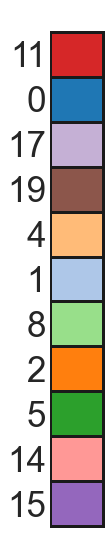

In [190]:
c=np.array([colors_rgb_dict[i] for i in cluster_label_order])

# legend
fig, ax = plt.subplots(figsize=(1,10))
ax.barh(y=range(len(colors_rgb_dict.values())), 
        color=c/255,
        width=1, 
        height=1,
        edgecolor='k',
        linewidth=3,
       )
_ = plt.yticks(range(len(colors_rgb_dict.values())), cluster_label_order, rotation=0, size=35)
_ = plt.xticks([])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.tick_params(axis=u'both', which=u'both',length=0)
# ax.yaxis.tick_right()
ax.invert_yaxis()
ax.grid(False)


In [191]:
size = 1000

for d in adata.obs.Dataset.unique():
    adata_donor = adata_CN[adata_CN.obs.Dataset == d, :]

    # Create combined images
    y_max, x_max = get_img_size(arrangement[d])
    img_combined = np.zeros((y_max, x_max, 3), dtype=np.uint8)

    for i in adata_donor.obs.ROI.unique():
        if i not in arrangement[d].keys():
            continue

        # Get dataset
        adata_subset = adata_donor[adata_donor.obs.ROI == i, :]

        # Get mask
        mask = masks[d][str(int(i))]

        # Get label2cell dict
        label2cell = {}
        for ii,l in enumerate(labels):
            cell_id = adata_subset[adata_subset.obs.CN== l].obs.Cell.to_list()
            label2cell[ii] = cell_id

        img = create_clustered_cell(mask, label2cell, colors_rgb)

        # Insert to combine image
        y = max(0, arrangement[d][i][0] - 1)
        x = max(0, arrangement[d][i][1] - 1)
        img_combined[y : y + size, x : x + size] = img

    save_path = p_dir / "figures" / "clustering" / f"LDA_Cluster_subset{d}.png"
    img_combined = Image.fromarray(img_combined)
    img_combined.save(save_path)


In [30]:
# adata_path = data_dir / "metadata" / f"combined_10_07_LDA.h5ad"
# adata.write(adata_path)